In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Python Spark Credit Card Fraud ")\
        .getOrCreate()

In [2]:
import pyspark
data_cb = spark.read.load('creditcard.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')
type(data_cb)
pyspark.sql.dataframe.DataFrame

pyspark.sql.dataframe.DataFrame

In [3]:
Freq = data_cb.groupBy("Class").count()
Freq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



## Equilibrage des données 

Distribution des classes dans l’ensemble de données 
0    0.998273
1    0.001727
Name: Class, dtype: float64


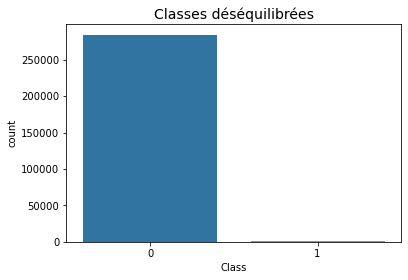

In [4]:
data= data_cb.toPandas()
data= data.sample(frac=1)
fraud = data.loc[data['Class'] == 1]
non_fraud = data.loc[data['Class'] == 0][:492]
import seaborn as sns
from matplotlib import pyplot as plt
print('Distribution des classes dans l’ensemble de données ')
print(data['Class'].value_counts()/len(data))
sns.countplot('Class', data=data)
plt.title('Classes déséquilibrées', fontsize=14)
plt.show()

In [5]:
import pandas as pd
data= data_cb.toPandas()
data= data.sample(frac=1)
# class fraud  == 1
# class non-fraud == 0
fraud = data.loc[data['Class'] == 1]
non_fraud = data.loc[data['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud, non_fraud])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.shape

(984, 31)

Distribution des classes dans l’ensemble de données 
1    0.5
0    0.5
Name: Class, dtype: float64


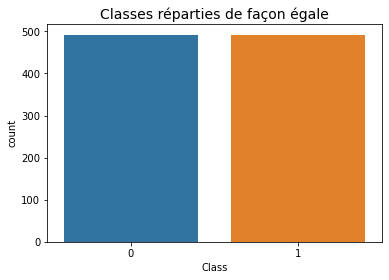

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
print('Distribution des classes dans l’ensemble de données ')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df)
plt.title('Classes réparties de façon égale', fontsize=14)
plt.show()

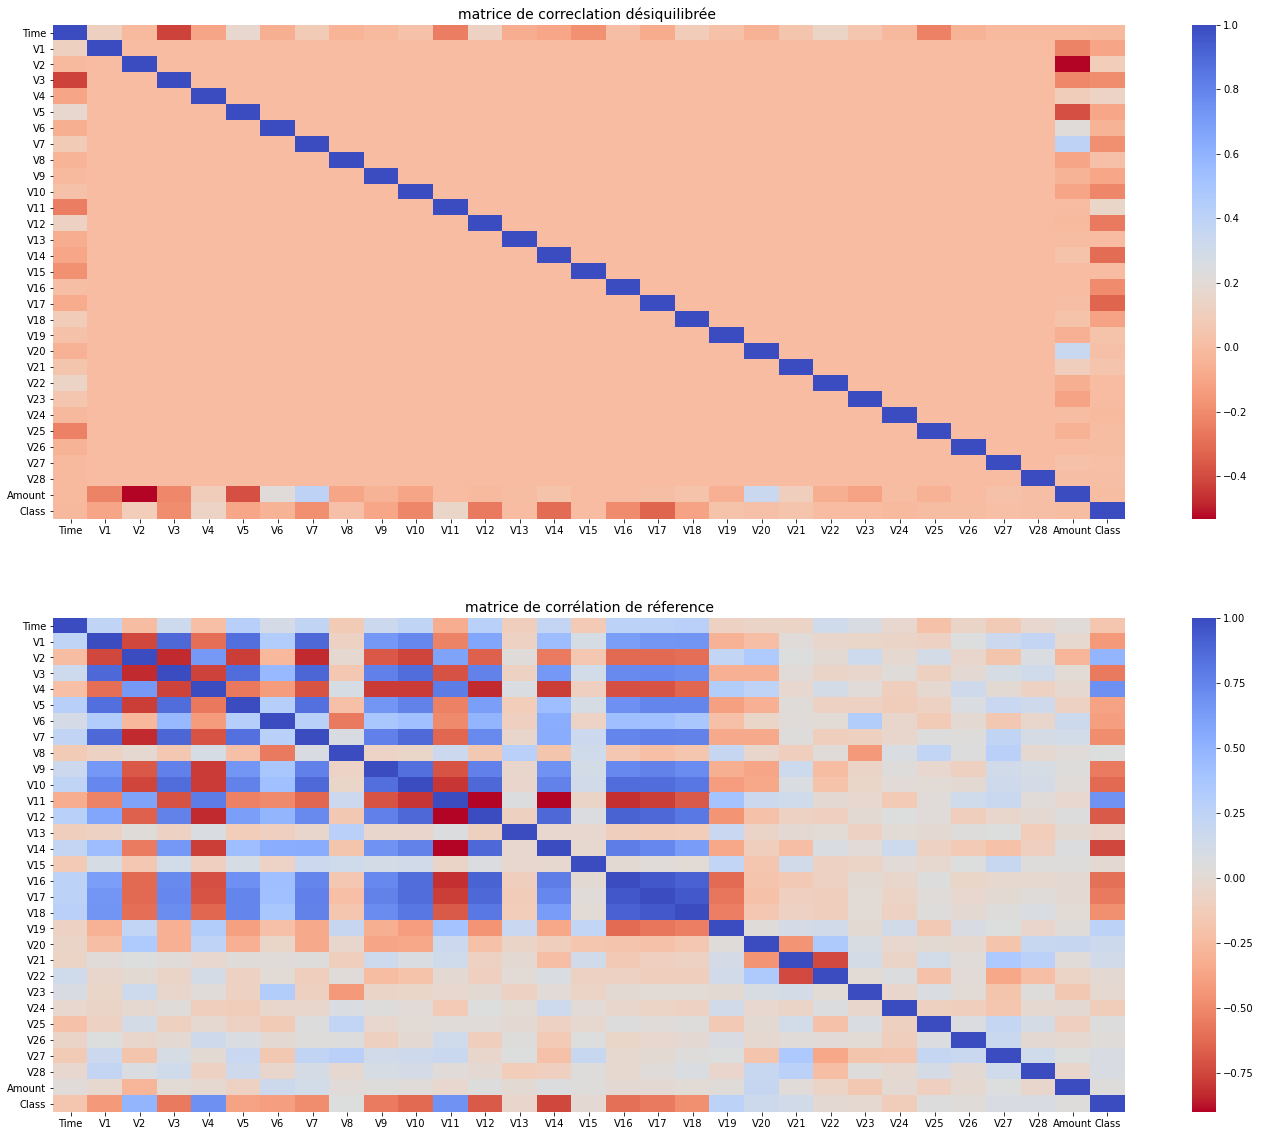

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("matrice de correclation désiquilibrée ", fontsize=14)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('matrice de corrélation de réference', fontsize=14)
plt.show()

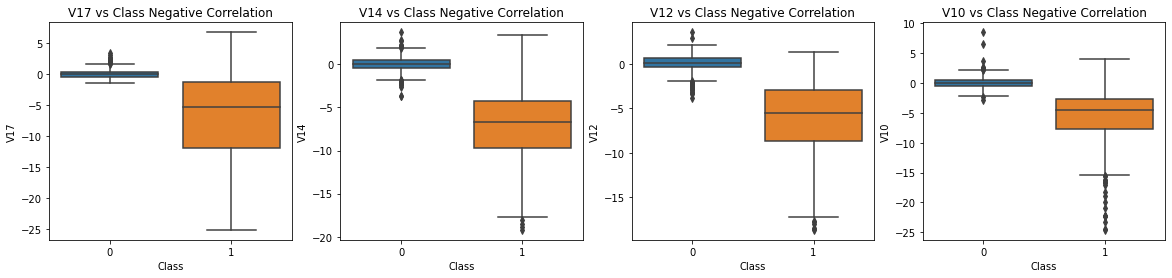

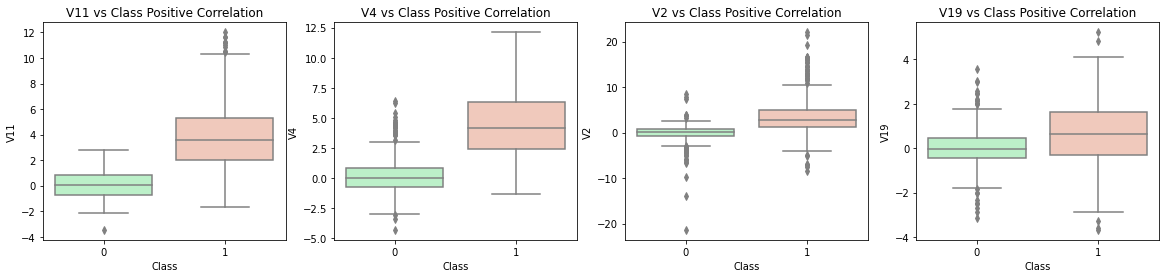

In [8]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
# Corrélations négatives avec notre classe (Plus la valeur du feature est faible, plus il est probable qu’il s’agit d’une transaction de fraude)
sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V14", data=new_df,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')
plt.show()
colors = ['#B3F9C5', '#f9c5b3']
f, axes = plt.subplots(ncols=4, figsize=(20,4))
#  correlations positives (Plus la valeur du feature est élevée, plus la probabilité augmente qu’il s’agit d’une transaction de fraude)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')
plt.show()

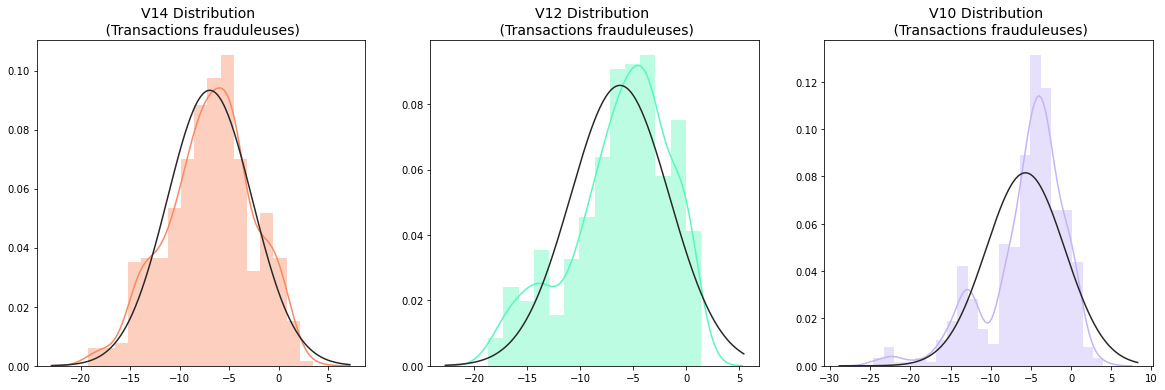

In [9]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Transactions frauduleuses)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Transactions frauduleuses)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Transactions frauduleuses)', fontsize=14)

plt.show()

In [10]:
import numpy as np
# # -----> V14 Suppression des valeurs aberrantes
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)
# -----> V12 suppression des valeurs aberrantes des transactions frauduleuses
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)
# Suppression des valeurs aberrantes V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.0499976898594, -18.8220867423816, -19.2143254902614, -18.4937733551053]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.0475965708216, -18.6837146333443, -18.5536970096458]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-16.6011969664137, -18.271168

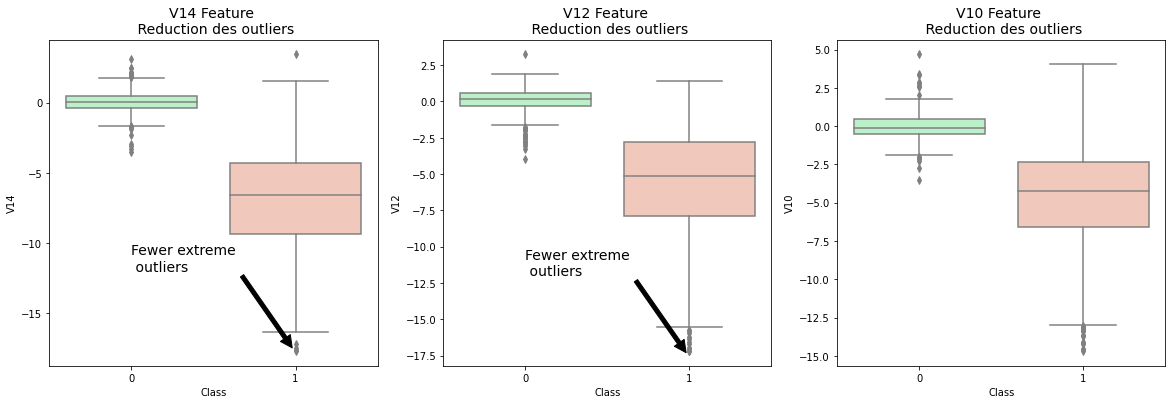

In [16]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
colors = ['#B3F9C5', '#f9c5b3']
# Boxplots avec des valeurs aberrantes supprimées
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction des outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction des outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction des outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
plt.show()

In [11]:
dfff = spark.createDataFrame(new_df)
from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfff = dfff.withColumn("idx", row_number().over(win))

## Apprentissage automatique

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [13]:
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31])) # Dense Vector required in spark to train the data
training_df = spark.createDataFrame(training_df,["features","label","index"])
training_df = training_df.select("index","features","label")
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [14]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  397|
|    1|  357|
+-----+-----+



In [15]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   93|
|    1|  100|
+-----+-----+



### GBT

In [16]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)
model = gbt.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   97|
|       1.0|   96|
+----------+-----+



In [52]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9193531055233181

In [17]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   89|
|              0|  104|
+---------------+-----+



In [18]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   93|
|    1|  100|
+-----+-----+



In [19]:
from pyspark.sql.functions import col
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

89.0

In [20]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print("vrai positif: ",tp,"\n vrai négatif: ",tn,"\n faux positif: ",fp,"\n faux négatif: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))


[[86  7]
 [11 89]]
vrai positif:  89 
 vrai négatif:  86 
 faux positif:  7 
 faux négatif:  11
Recall:  0.89
Precision:  0.9270833333333334


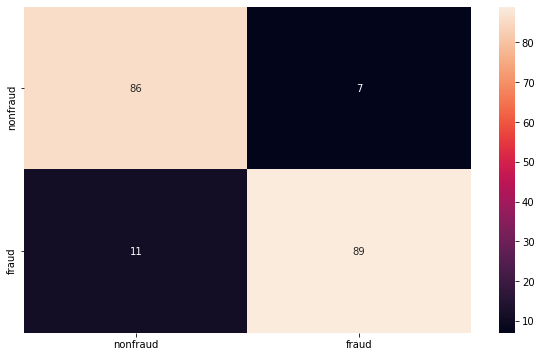

In [21]:
cm =confusion_matrix(y_true, y_pred)  
index = ['nonfraud','fraud']  
columns = ['nonfraud','fraud']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        93
           1       0.93      0.89      0.91       100

    accuracy                           0.91       193
   macro avg       0.91      0.91      0.91       193
weighted avg       0.91      0.91      0.91       193



In [23]:
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

Recall:  0.89
Precision:  0.9270833333333334


### arbre de décision

In [24]:
from pyspark.ml.classification import DecisionTreeClassifier
DT = DecisionTreeClassifier(featuresCol="features")
model = DT.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  100|
|       1.0|   93|
+----------+-----+



In [25]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.8484408602150537

In [26]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   87|
|              0|  106|
+---------------+-----+



In [27]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   93|
|    1|  100|
+-----+-----+



In [28]:
from pyspark.sql.functions import col
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

87.0

In [29]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print("vrai positif: ",tp,"\n vrai négatif: ",tn,"\n faux positif: ",fp,"\n faux négatif: ",fn)


#print("vrai positif: ",tp,"\n vrai négatif: ",tn,"\n faux positif: ",fp,"\n faux négatif: ",fn)


[[87  6]
 [13 87]]
vrai positif:  87 
 vrai négatif:  87 
 faux positif:  6 
 faux négatif:  13


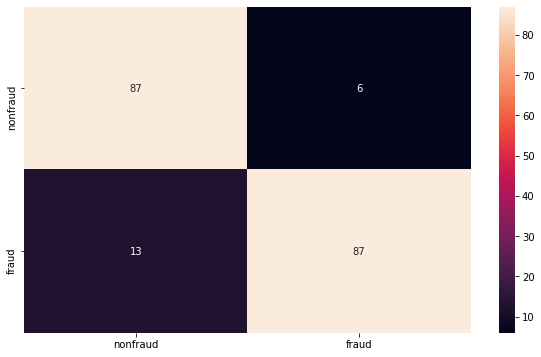

In [31]:
cm =confusion_matrix(y_true, y_pred)  
index = ['nonfraud','fraud']  
columns = ['nonfraud','fraud']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        93
           1       0.94      0.87      0.90       100

    accuracy                           0.90       193
   macro avg       0.90      0.90      0.90       193
weighted avg       0.90      0.90      0.90       193



In [33]:
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

Recall:  0.87
Precision:  0.9354838709677419


### Random Forest

In [34]:
from pyspark.ml.classification import RandomForestClassifier
Rf = RandomForestClassifier(featuresCol="features", numTrees=3)
model = Rf.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  104|
|       1.0|   89|
+----------+-----+



In [35]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9810752688172042

In [36]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   87|
|              0|  106|
+---------------+-----+



In [37]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   93|
|    1|  100|
+-----+-----+



In [38]:
from pyspark.sql.functions import col
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

87.0

In [39]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print("vrai positif: ",tp,"\n vrai négatif: ",tn,"\n faux positif: ",fp,"\n faux négatif: ",fn)


[[91  2]
 [13 87]]
vrai positif:  87 
 vrai négatif:  91 
 faux positif:  2 
 faux négatif:  13


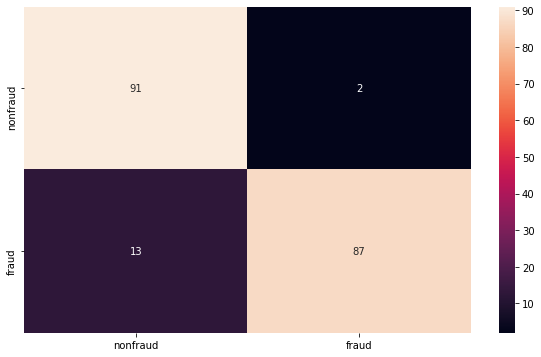

In [40]:
cm =confusion_matrix(y_true, y_pred)  
index = ['nonfraud','fraud']  
columns = ['nonfraud','fraud']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92        93
           1       0.98      0.87      0.92       100

    accuracy                           0.92       193
   macro avg       0.93      0.92      0.92       193
weighted avg       0.93      0.92      0.92       193



In [42]:
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

Recall:  0.87
Precision:  0.9775280898876404
